<h1>How to analyze T-maze EEG-fMRI data</h1>

<h2>fMRI preprocessing</h2>

<p>Basic workflow performing motion correction, coregistration of the fMRI
data to T1 images, smoothing and artifact detection. The workflow
is based on this nipyoe turotial: https://miykael.github.io/nipype_tutorial/notebooks/example_preprocessing.html</p>

In [36]:
from os.path import join as opj
import os

import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

import numpy as np
import pylab as plt

In [37]:
experiment_dir = 'output'
output_dir = 'datasink'
working_dir = '/Users/maltegueth/nipype'

# subject list
subject_list = ['01','02','03']

# task name
task_list = ['tmaze']

# Smoothing width
fwhm = [5]

# TR
TR = 2

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

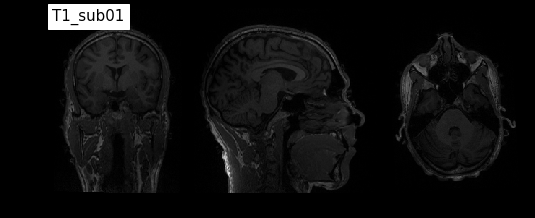

In [20]:
from nilearn import plotting
plotting.plot_epi(working_dir + '/data/sub-01_t1.nii',
    title="T1_sub01", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

In [38]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
                       name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                             name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
                          name="art")

# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                    name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                           name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                       name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                       name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                            name="applywarp_mean")

In [39]:
# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [40]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternative to DataGrabber)
anat_file = opj('sub-{subject_id}_t1.nii')
func_file = opj('sub-{subject_id}_ses-test_task-{task_name}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=working_dir + '/data'),
                               name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                         name="datasink")

In [41]:
## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [42]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

190225-10:44:01,43 nipype.workflow INFO:
	 Generated workflow graph: /Users/maltegueth/nipype/preproc/graph.png (graph2use=colored, simple_form=True).


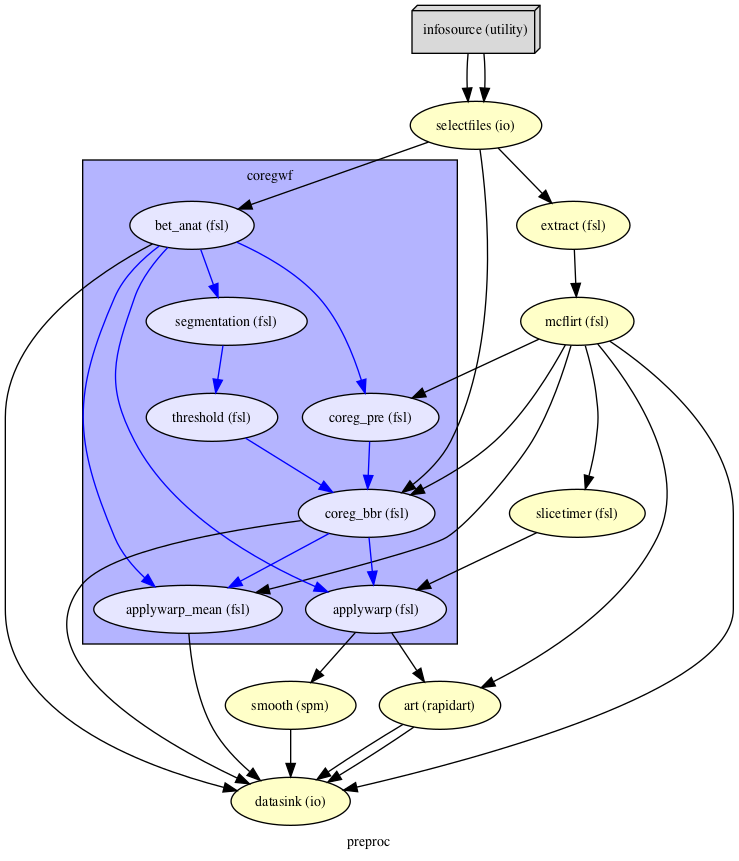

In [26]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

190225-10:44:08,688 nipype.workflow INFO:
	 Generated workflow graph: /Users/maltegueth/nipype/preproc/graph.png (graph2use=flat, simple_form=True).


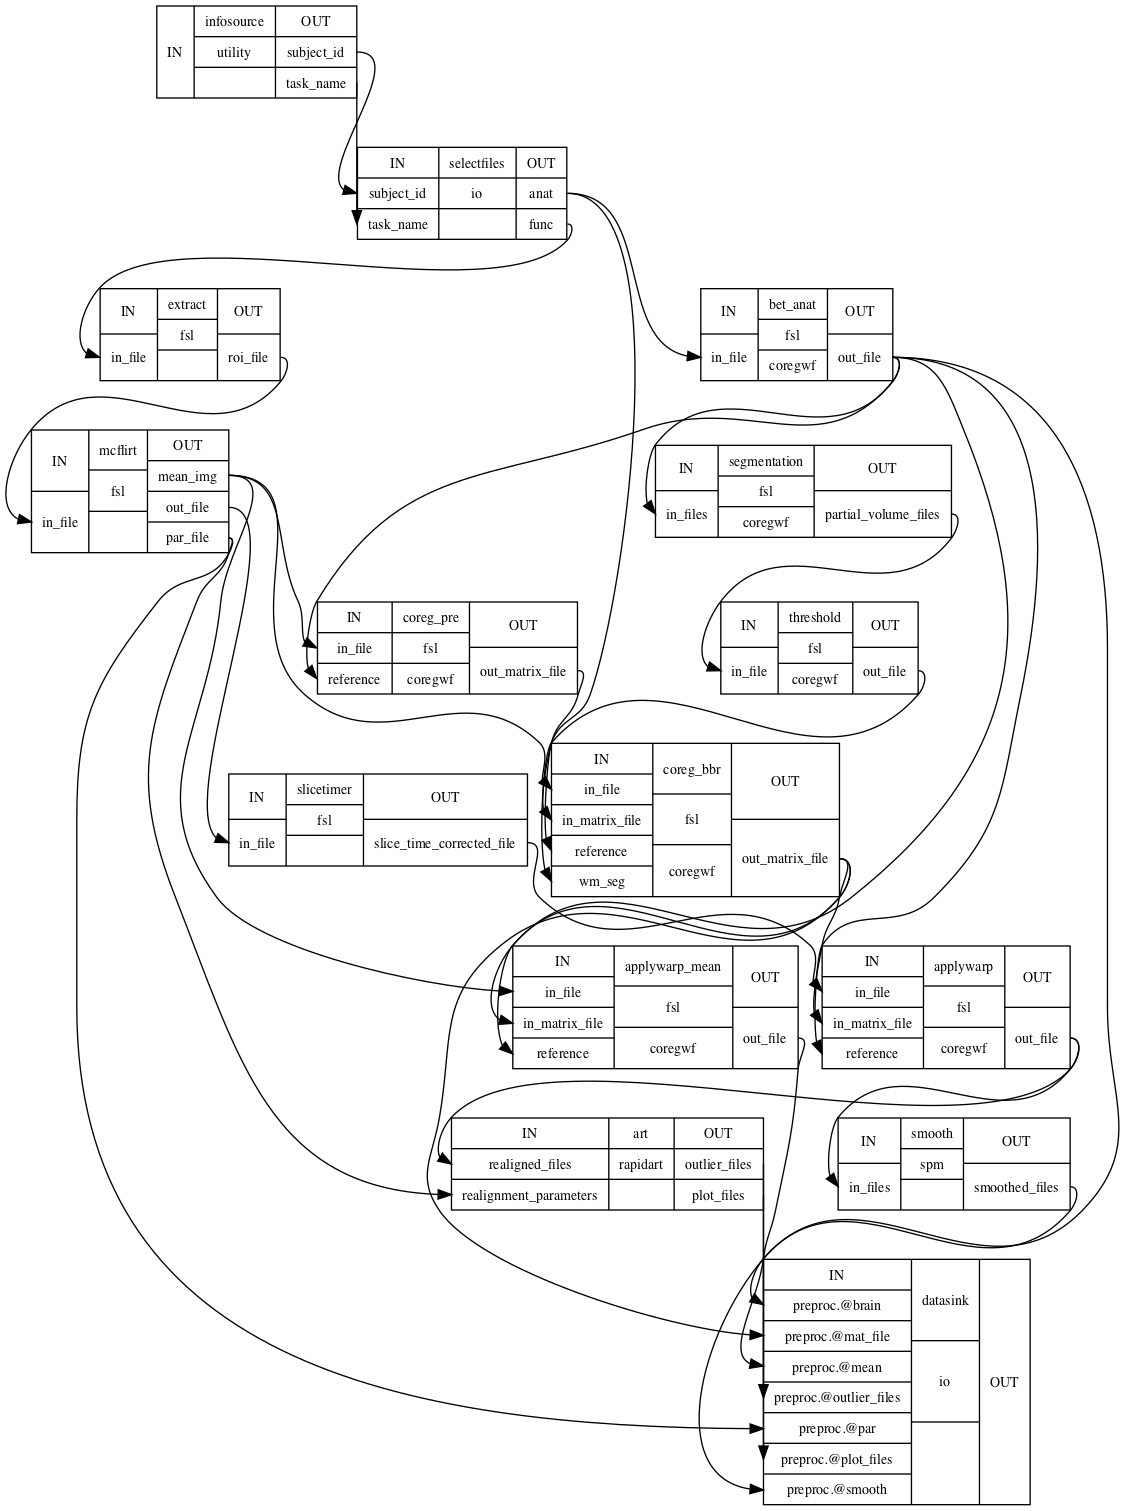

In [27]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [62]:
# Finally, run everything and hope it doesn't crash
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190227-14:13:27,216 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
190227-14:13:27,243 nipype.workflow INFO:
	 Running in parallel.
190227-14:13:27,247 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
190227-14:13:27,809 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/Users/maltegueth/nipype/preproc/_subject_id_03_task_name_tmaze/selectfiles".
190227-14:13:27,824 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190227-14:13:27,839 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
190227-14:13:29,254 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
190227-14:13:29,260 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
190227-14:13:29,897 nipype.workflow INFO:
	 [Job 1] Cached (preproc.coregwf.bet_anat

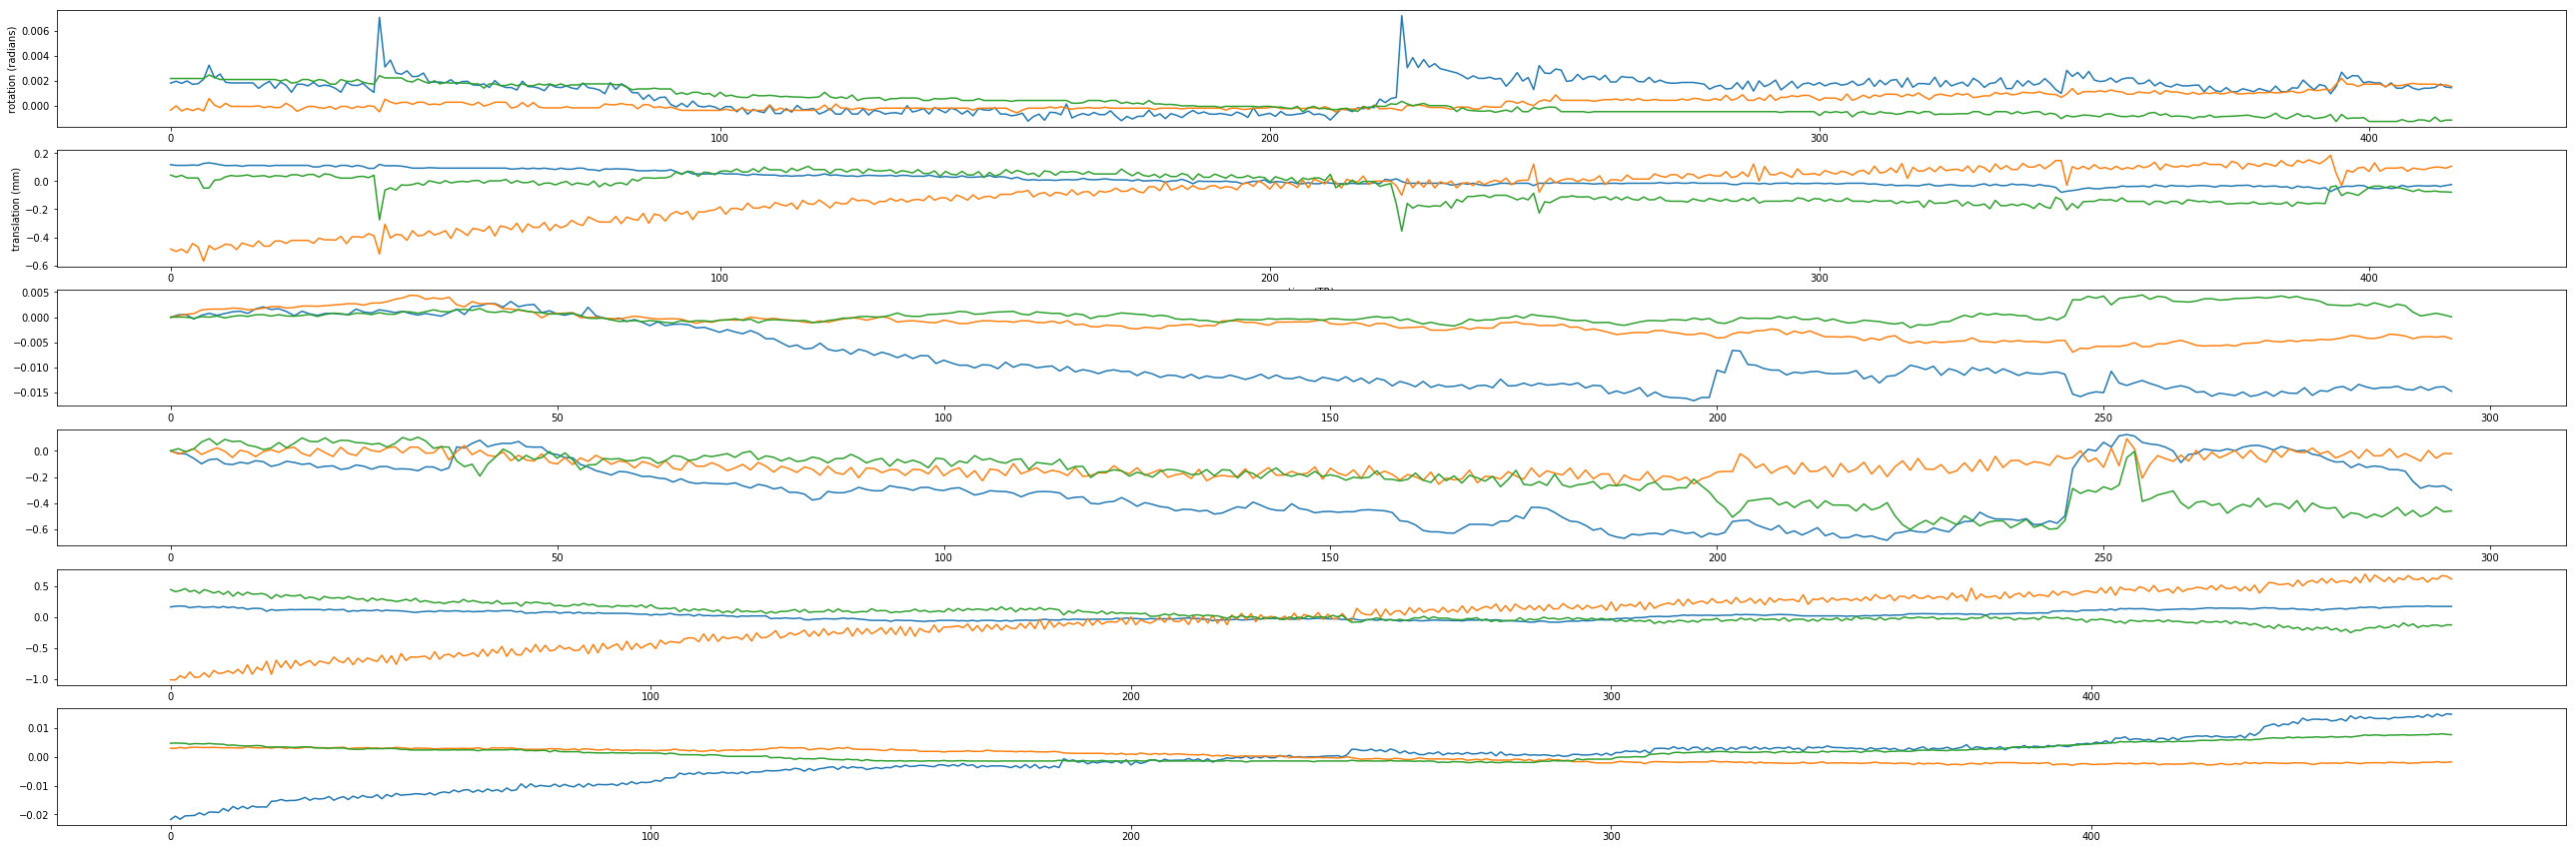

In [49]:
txt1 = np.loadtxt('/Users/maltegueth/nipype/preproc/_subject_id_01_task_name_tmaze/mcflirt/sub-01_ses-test_task-tmaze_bold_roi_mcf.nii.par')
txt2 = np.loadtxt('/Users/maltegueth/nipype/preproc/_subject_id_02_task_name_tmaze/mcflirt/sub-02_ses-test_task-tmaze_bold_roi_mcf.nii.txt')
txt3 = np.loadtxt('/Users/maltegueth/nipype/preproc/_subject_id_03_task_name_tmaze/mcflirt/sub-03_ses-test_task-tmaze_bold_roi_mcf.nii.par')

fig, axes = plt.subplots(6, 1, figsize=(45, 15))

axes[0].set_ylabel('rotation (radians)')
axes[0].plot(txt1[0:, :3])
axes[1].plot(txt1[0:, 3:])
axes[2].plot(txt2[0:, 3:])
axes[3].plot(txt2[0:, :3])
axes[4].plot(txt3[0:, 3:])
axes[5].plot(txt3[0:, :3])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

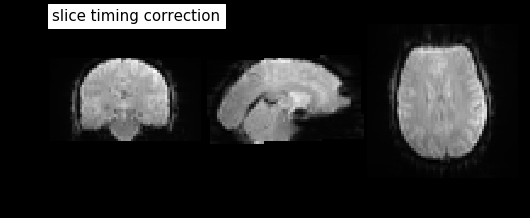

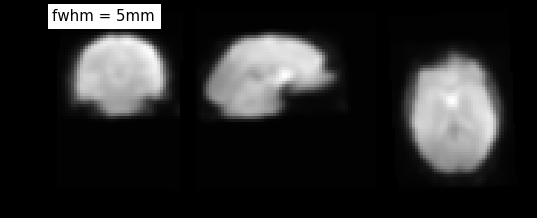

In [52]:
from nilearn import image, plotting
plotting.plot_epi(image.mean_img(opj('/Users/maltegueth/nipype/preproc/_subject_id_01_task_name_tmaze/slicetimer/sub-01_ses-test_task-tmaze_bold_roi_mcf_st.nii')),
                  title="slice timing correction", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')
plotting.plot_epi(image.mean_img(opj('/Users/maltegueth/nipype/preproc/_subject_id_01_task_name_tmaze/smooth/ssub-01_ses-test_task-tmaze_bold_roi_mcf_st_flirt.nii')),
                  title="fwhm = 5mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

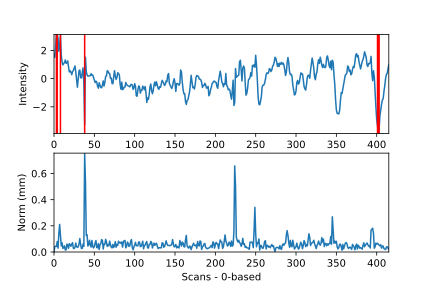

In [53]:
from IPython.display import SVG
SVG('/Users/maltegueth/nipype/preproc/_subject_id_01_task_name_tmaze/art/plot.sub-01_ses-test_task-tmaze_bold_roi_mcf_st_flirt.svg')

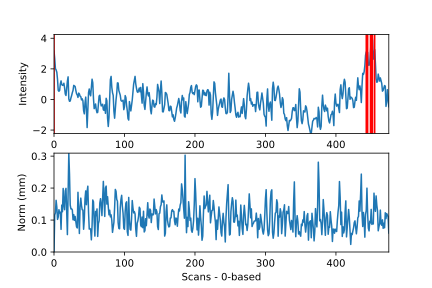

In [54]:
SVG('/Users/maltegueth/nipype/preproc/_subject_id_03_task_name_tmaze/art/plot.sub-03_ses-test_task-tmaze_bold_roi_mcf_st_flirt.svg')

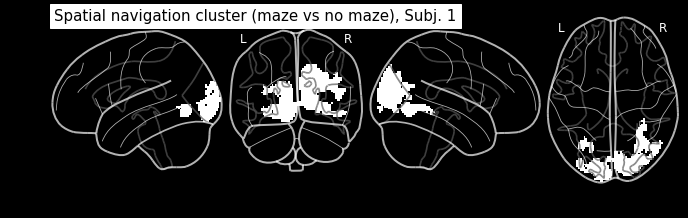

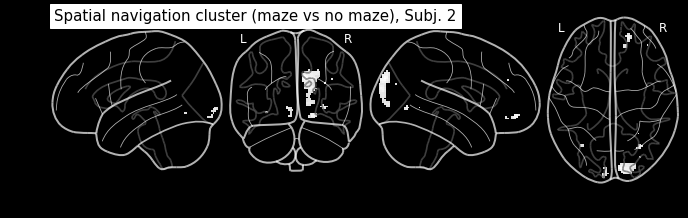

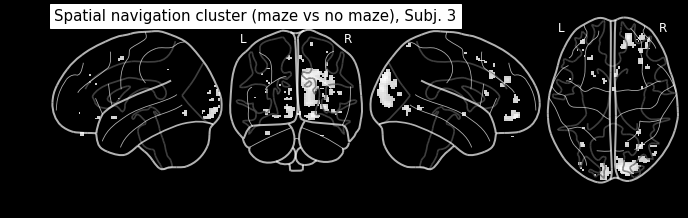

In [23]:
import nibabel as nb
from nilearn.plotting import plot_glass_brain

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub01/maze_nomaze.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='Spatial navigation cluster (maze vs no maze), Subj. 1')

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub02/maze_nomaze.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='Spatial navigation cluster (maze vs no maze), Subj. 2')

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub03/maze_nomaze.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='Spatial navigation cluster (maze vs no maze), Subj. 3')

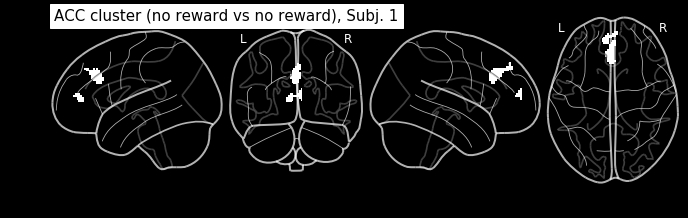

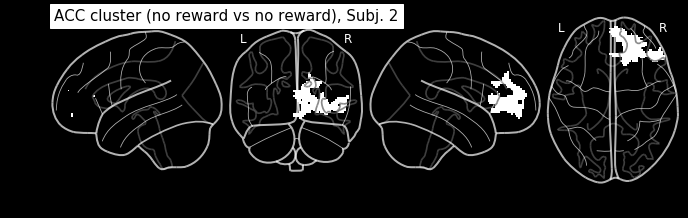

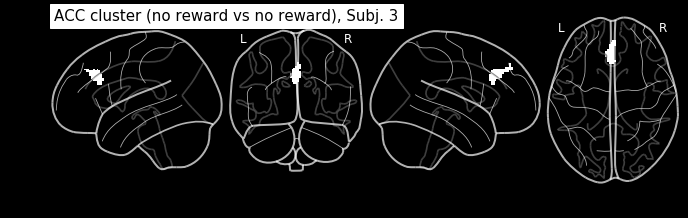

In [35]:
plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub01/norew_rew_acc.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='ACC cluster (no reward vs no reward), Subj. 1')

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub02/norew_rew_acc.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='ACC cluster (no reward vs no reward), Subj. 2')

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub03/norew_rew_acc.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='ACC cluster (no reward vs no reward), Subj. 3')

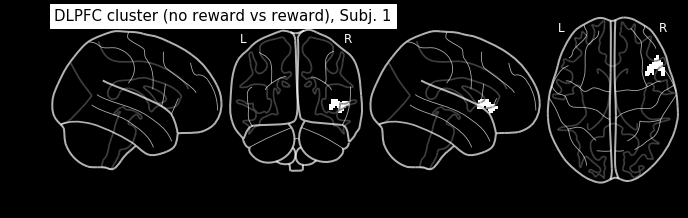

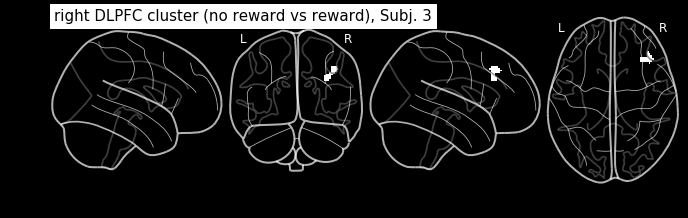

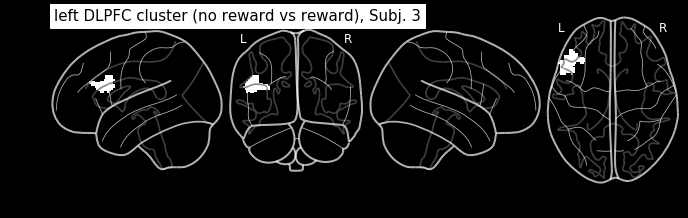

In [33]:
plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub01/norew_rew_dlpfc.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='DLPFC cluster (no reward vs reward), Subj. 1');

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub03/norew_rew_dlpfc1.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='right DLPFC cluster (no reward vs reward), Subj. 3');

plot_glass_brain('/Volumes/INTENSO/EEG_fMRI_tmaze/clusters/sub03/norew_rew_dlpfc2.nii',
                 colorbar=False, display_mode='lyrz', black_bg=True,
                 title='left DLPFC cluster (no reward vs reward), Subj. 3');